<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator

# Data Process

In [ ]:
### Import data & dropna
df = pd.read_excel('d1.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])
print(df)

                      Date      NOx
0      2015-01-01 00:15:00  62.2314
1      2015-01-01 00:30:00  75.7350
2      2015-01-01 00:45:00  70.4414
5      2015-01-01 01:30:00  29.6205
6      2015-01-01 01:45:00  53.4148
...                    ...      ...
210426 2020-12-31 22:45:00  11.7719
210427 2020-12-31 23:00:00  25.4470
210428 2020-12-31 23:15:00  34.3861
210429 2020-12-31 23:30:00  47.5379
210430 2020-12-31 23:45:00  65.7220

[204685 rows x 2 columns]


(34176,)


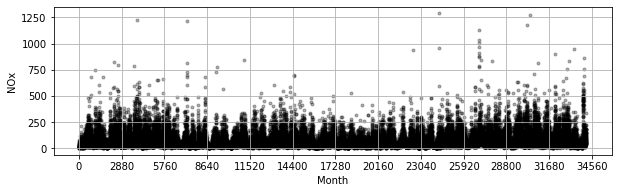

In [ ]:
### Data selection(date & NOx)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(data))
plt.scatter(x, data, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(4*24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(data.shape)

(8544,)


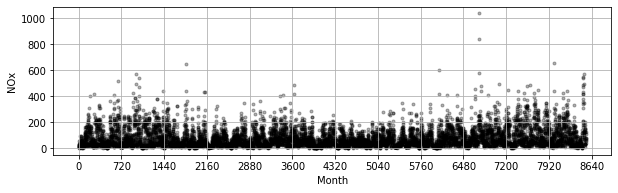

In [ ]:
### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)

fig = plt.figure(figsize = (10, 6))
ax2 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(avg))
plt.scatter(x, avg, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(avg.shape)

In [ ]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
avg = avg.reshape(len(avg), 1)
data = scaler.fit_transform(avg)
# data = data.reshape(len(data),)

data.shape

(8544, 1)

# Build dataset

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_lag = 5
n_features = 1
reframed = series_to_supervised(data, n_lag, 1)
reframed.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,0.055031,0.029798,0.024628,0.033146,0.007898,0.012555
6,0.029798,0.024628,0.033146,0.007898,0.012555,0.006292
7,0.024628,0.033146,0.007898,0.012555,0.006292,0.004754
8,0.033146,0.007898,0.012555,0.006292,0.004754,0.004767
9,0.007898,0.012555,0.006292,0.004754,0.004767,0.003985


In [ ]:
### Build data set
values = reframed.values
n_val_hours = 3*24
train = values[:-n_val_hours, :]
test = values[-n_val_hours:,:]

train_X, train_y = train[:-n_lag, :-1], train[:-n_lag, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8462, 5, 1) (8462,) (72, 5, 1) (72,)


# LSTM Construction & Training

In [ ]:
### Configure
lr = 3e-5
n_epochs = 300
batchsize = 128
n_neuron = 150

In [ ]:
### Contruct the LSTM
def build_lstm():

  model = Sequential()
  # model.add(LSTM(n_neuron, input_shape=(n_in, n_features)))
  model.add(LSTM(n_neuron, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  #model.add(Activation("sigmoid"))
  model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss='mae')

  return model

Epoch 1/300
67/67 [==============================] - 5s 22ms/step - loss: 0.0606 - val_loss: 0.1126
Epoch 2/300
67/67 [==============================] - 1s 9ms/step - loss: 0.0444 - val_loss: 0.0922
Epoch 3/300
67/67 [==============================] - 1s 10ms/step - loss: 0.0415 - val_loss: 0.0863
Epoch 4/300
67/67 [==============================] - 1s 9ms/step - loss: 0.0395 - val_loss: 0.0806
Epoch 5/300
67/67 [==============================] - 1s 9ms/step - loss: 0.0378 - val_loss: 0.0767
Epoch 6/300
67/67 [==============================] - 1s 10ms/step - loss: 0.0371 - val_loss: 0.0741
Epoch 7/300
67/67 [==============================] - 1s 9ms/step - loss: 0.0366 - val_loss: 0.0729
Epoch 8/300
67/67 [==============================] - 1s 10ms/step - loss: 0.0363 - val_loss: 0.0724
Epoch 9/300
67/67 [==============================] - 1s 10ms/step - loss: 0.0362 - val_loss: 0.0719
Epoch 10/300
67/67 [==============================] - 1s 9ms/step - loss: 0.0360 - val_loss: 0.0714
Epoc

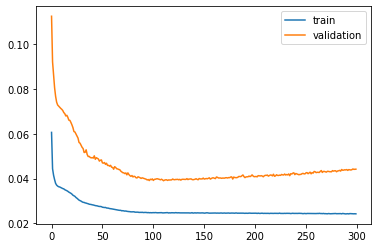

In [ ]:
### Training LSTM
def model_fit(x_train, y_train, x_val, y_val):
    
    model = build_lstm()

    my_callbacks = [ModelCheckpoint(filepath='my_model.h5', save_best_only=True)]
    # my_callbacks = [EarlyStopping(patience=100), ModelCheckpoint(filepath='my_model.h5', save_best_only=True), ReduceLROnPlateau(factor = 0.1, patience = 50)]
    history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, callbacks=my_callbacks, validation_data=(x_val, y_val))
    # history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, validation_data=(x_val, y_val))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

model = model_fit(train_X, train_y, test_X, test_y)
model = load_model('my_model.h5')

# Results visualization & Analysis

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
Prediction = inv_yhat[:,0]

In [ ]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
Truth = inv_y[:,0]

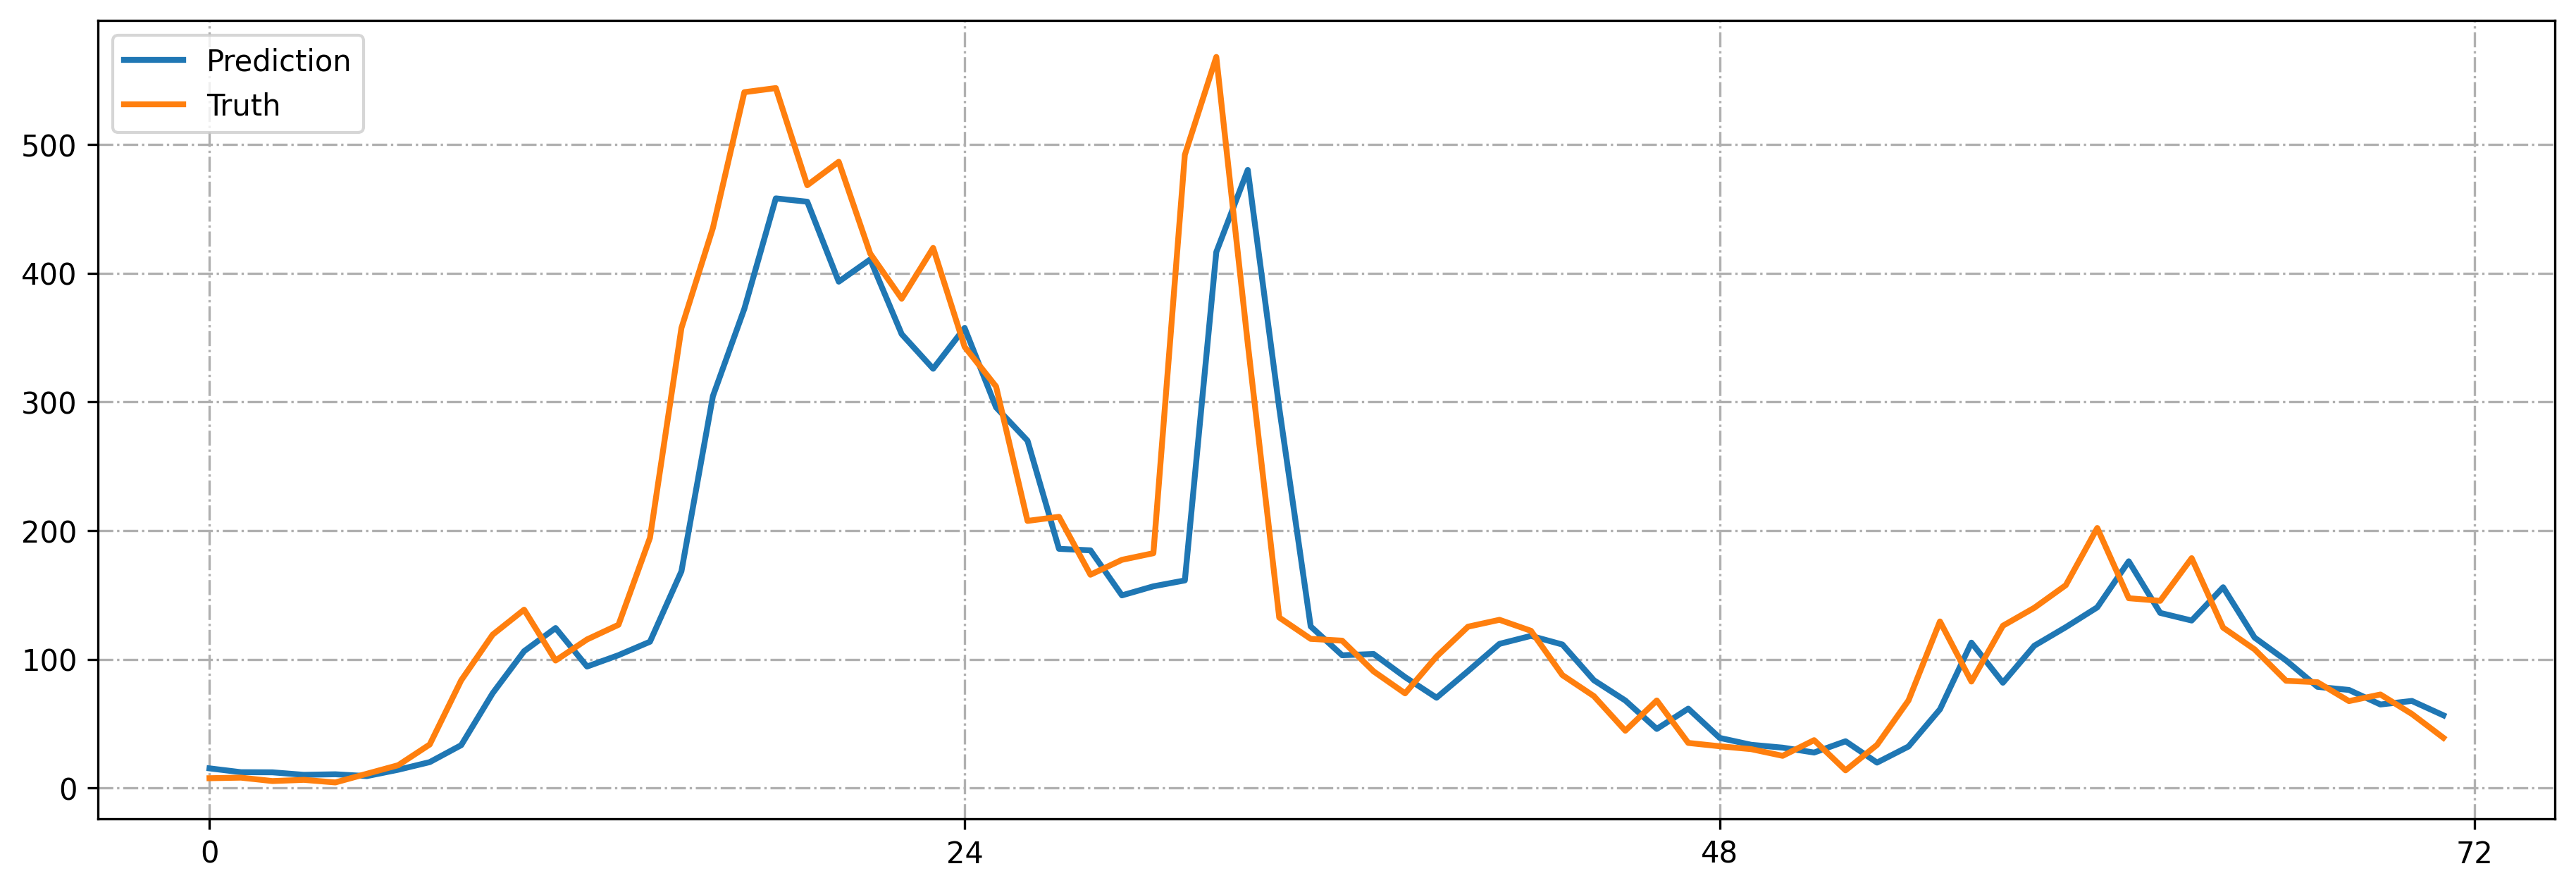

In [ ]:
### Visualization
x = [x for x in range(n_val_hours)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [ ]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE)
print('RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction)
print('MAE: %.3f' %MAE)
MAPE = np.mean(np.abs((Truth - Prediction) / Truth)) * 100
print('MAPE: %.3f' %MAPE)
MedAE = median_absolute_error(Truth, Prediction)
print('MedAE: %.3f' %MedAE)
r2_score = r2_score(Truth, Prediction)
print('r2_score: %.3f' %r2_score)
explained_variance_score = explained_variance_score(Truth, Prediction)
print('explained_variance_score: %.3f' %explained_variance_score)

RMSE: 67.794
MAE: 40.301
MAPE: 33.012
MedAE: 23.025
r2_score: 0.794
explained_variance_score: 0.811
